In [1]:
import numpy as np
import pandas as pd

In [2]:
import consts
import util

In [3]:
dataset = pd.read_csv('../data/arc_mini_comb_red.csv', index_col=0)
dataset

,Floral,Fruity,Woody,Odourless,ATS1v,AATS1dv,Xpc-4dv,ETA_Epsilon_2,BCUTd-1h,MATS3m,...,ATS3are,ETA_eta_RL,FP973,FP98,FP132,FP981,FP975,GATS8are,GATS5se,AETA_beta_ns
107,0,0,0,1,-0.688753,0.876789,-0.447018,0.426587,-0.094208,-0.725538,...,-0.824524,-0.375002,0.0,0.0,0.0,0.0,0.0,1.797623,-1.022452,1.319320
126,0,0,1,0,-1.271507,1.915525,-0.474136,0.933438,-0.085521,-0.744025,...,-1.350477,-0.810142,0.0,0.0,0.0,0.0,0.0,-0.844018,0.233485,2.127226
174,0,0,0,1,-2.419998,-0.962640,-0.698357,4.417754,-1.550173,1.173829,...,-1.782962,-1.900930,0.0,0.0,0.0,0.0,0.0,-0.844018,-2.104701,-1.340860
177,0,0,0,1,-2.628274,-0.489258,-0.698357,2.327197,-1.639289,-1.369582,...,-2.098626,-2.127095,0.0,0.0,0.0,0.0,0.0,-0.844018,-2.104701,0.609938
179,0,0,0,1,-1.925038,0.056953,-0.364237,2.327197,0.007164,-1.377420,...,-1.405254,-1.571397,0.0,0.0,0.0,0.0,0.0,-0.844018,-2.104701,-0.365461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139817334,0,0,0,1,0.858521,0.086084,-0.577963,1.097371,0.023529,1.885039,...,1.139744,0.989605,0.0,0.0,0.0,0.0,0.0,0.605788,0.066804,-0.652343
139888962,1,0,0,0,-0.442071,0.537618,-0.522174,1.281919,-0.103823,0.782379,...,-0.303665,-0.131646,0.0,0.0,0.0,0.0,0.0,-0.698768,1.297686,-0.528027
139889144,0,0,0,1,0.043687,0.646860,-0.445996,-0.062104,-0.085480,-0.142734,...,-0.471485,0.320684,0.0,0.0,0.0,0.0,0.0,-0.651040,1.403952,1.027967
140998267,1,0,0,0,0.485958,0.379061,0.374715,0.497919,1.396236,-0.669641,...,0.320507,0.537192,0.0,0.0,0.0,0.0,0.0,-0.413836,-0.463724,-0.121611


In [4]:
possible_target_cols = np.array(['Floral', 'Fruity', 'Woody', 'Odourless'])
target_cols = possible_target_cols
target_cols

array(['Floral', 'Fruity', 'Woody', 'Odourless'], dtype='<U9')

In [5]:
# feature_cols = dataset.columns[possible_target_cols.shape[0]:]
feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+326]
feature_cols

Index(['ATS1v', 'AATS1dv', 'Xpc-4dv', 'ETA_Epsilon_2', 'BCUTd-1h', 'MATS3m',
       'ATSC5dv', 'BIC4', 'GATS2se', 'GATS3e',
       ...
       'AATSC7d', 'EState_VSA1', 'GGI7', 'FP735', 'FP457', 'FP345', 'FP785',
       'PubchemFP797', 'KRFP3716', 'PubchemFP672'],
      dtype='object', length=326)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from hypll import nn as hnn
from hypll.tensors import TangentTensor

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(MLP, self).__init__()
        torch.manual_seed(consts.TORCH_MANUAL_SEED)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)
        x = F.softmax(x.tensor, dim=1)
        return x

# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define training function
def train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [7]:
num_hidden_layers = 0
layer_size = 128
lr = 0.003
weight_decay = 0.01
batch_size = 96
BCE_weights_power = 0.5
BCE_weights_factor = 1.2
epochs = 20
curvature  = -1

In [8]:
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# Prepare data
features = dataset[feature_cols].apply(util.normalize_column, axis=0).fillna(0).values
labels = dataset[target_cols].values

manifold = PoincareBall(c=Curvature(curvature))

METRICS = ['acc', 'hamm', 'prec', 'sens', 'f1', 'aps']

eval_stats = {'loss': {'train': [], 'val': []}}
for metric in METRICS:
    eval_stats[metric] = {'train': [],
                          'val': []}

# Initialize cross-validation
kf = KFold(n_splits=consts.KFOLDS, shuffle=True, random_state=consts.KFOLD_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an empty list to store parameters
all_model_params = []
# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(features, labels)):
    print(f'Fold {fold + 1}')

    # Split data into train and validation sets
    train_features, val_features = features[train_idx], features[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create DataLoader for training and validation
    train_dataset = CustomDataset(train_features, train_labels)
    val_dataset = CustomDataset(val_features, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = MLP(input_size=len(feature_cols), output_size=len(target_cols), layer_size=layer_size, num_hidden_layers=num_hidden_layers, manifold=manifold).to(device)
    # criterion = nn.BCELoss()

    possible_label_occurences = torch.tensor(dataset[possible_target_cols].mean())
    indices = np.where(np.isin(possible_target_cols, target_cols))[0]
    label_occurences = possible_label_occurences[indices]

    bce_positive_weights = util.calc_bce_positive_weights(label_occurences, BCE_weights_power, BCE_weights_factor)

    print(bce_positive_weights)
    criterion = nn.BCEWithLogitsLoss(pos_weight=bce_positive_weights)

    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    eval_stats_fold = {'loss': {'train': [], 'val': []}}
    for metric in METRICS:
        eval_stats_fold[metric] = {'train': [],
                                    'val': []}

    for epoch in tqdm(range(epochs), desc="Epoch"):
        eval_stats_fold['loss']['train'].append(train_model(model, train_loader, criterion, optimizer, manifold, device))
        eval_stats_fold['loss']['val'].append(util.h_mini_evaluate_loss(model, val_loader, criterion, manifold, device))

        # Calculate and store specuracy
        # accuracy, hamm, precision, sensitivity, f1, aps
        eval_train = util.h_mini_evaluate_metrics(model, train_loader, manifold, device)
        eval_val = util.h_mini_evaluate_metrics(model, val_loader, manifold, device)
        for i, metric in enumerate(METRICS):
            eval_stats_fold[metric]['train'].append(eval_train[i])
            eval_stats_fold[metric]['val'].append(eval_val[i])

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {eval_stats_fold['loss']['train'][-1]:.4f}, Val Loss: {eval_stats_fold['loss']['val'][-1]:.4f}")

    eval_stats['loss']['train'].append(eval_stats_fold['loss']['train'])
    eval_stats['loss']['val'].append(eval_stats_fold['loss']['val'])
    for metric in METRICS:
        eval_stats[metric]['train'].append(eval_stats_fold[metric]['train'])
        eval_stats[metric]['val'].append(eval_stats_fold[metric]['val'])

    # Append parameters of the trained model
    all_model_params.append(model.state_dict())


Fold 1
tensor([4.1201, 4.0259, 6.0647, 3.9064], dtype=torch.float64)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.2124, Val Loss: 1.2108
Epoch 2/20, Train Loss: 1.1888, Val Loss: 1.2001
Epoch 3/20, Train Loss: 1.1770, Val Loss: 1.1924
Epoch 4/20, Train Loss: 1.1679, Val Loss: 1.1853
Epoch 5/20, Train Loss: 1.1594, Val Loss: 1.1800
Epoch 6/20, Train Loss: 1.1518, Val Loss: 1.1752
Epoch 7/20, Train Loss: 1.1447, Val Loss: 1.1709
Epoch 8/20, Train Loss: 1.1378, Val Loss: 1.1677
Epoch 9/20, Train Loss: 1.1318, Val Loss: 1.1645
Epoch 10/20, Train Loss: 1.1262, Val Loss: 1.1615
Epoch 11/20, Train Loss: 1.1210, Val Loss: 1.1589
Epoch 12/20, Train Loss: 1.1166, Val Loss: 1.1569
Epoch 13/20, Train Loss: 1.1127, Val Loss: 1.1553
Epoch 14/20, Train Loss: 1.1089, Val Loss: 1.1540
Epoch 15/20, Train Loss: 1.1055, Val Loss: 1.1526
Epoch 16/20, Train Loss: 1.1023, Val Loss: 1.1507
Epoch 17/20, Train Loss: 1.0994, Val Loss: 1.1505
Epoch 18/20, Train Loss: 1.0966, Val Loss: 1.1488
Epoch 19/20, Train Loss: 1.0941, Val Loss: 1.1486
Epoch 20/20, Train Loss: 1.0915, Val Loss: 1.1487
Fold 2
te

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.2150, Val Loss: 1.2013
Epoch 2/20, Train Loss: 1.1920, Val Loss: 1.1891
Epoch 3/20, Train Loss: 1.1806, Val Loss: 1.1808
Epoch 4/20, Train Loss: 1.1714, Val Loss: 1.1736
Epoch 5/20, Train Loss: 1.1631, Val Loss: 1.1678
Epoch 6/20, Train Loss: 1.1553, Val Loss: 1.1622
Epoch 7/20, Train Loss: 1.1480, Val Loss: 1.1579
Epoch 8/20, Train Loss: 1.1416, Val Loss: 1.1534
Epoch 9/20, Train Loss: 1.1355, Val Loss: 1.1498
Epoch 10/20, Train Loss: 1.1300, Val Loss: 1.1472
Epoch 11/20, Train Loss: 1.1249, Val Loss: 1.1447
Epoch 12/20, Train Loss: 1.1203, Val Loss: 1.1421
Epoch 13/20, Train Loss: 1.1165, Val Loss: 1.1400
Epoch 14/20, Train Loss: 1.1123, Val Loss: 1.1385
Epoch 15/20, Train Loss: 1.1084, Val Loss: 1.1372
Epoch 16/20, Train Loss: 1.1052, Val Loss: 1.1356
Epoch 17/20, Train Loss: 1.1022, Val Loss: 1.1339
Epoch 18/20, Train Loss: 1.0997, Val Loss: 1.1336
Epoch 19/20, Train Loss: 1.0971, Val Loss: 1.1321
Epoch 20/20, Train Loss: 1.0943, Val Loss: 1.1322
Fold 3
te

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.2145, Val Loss: 1.2025
Epoch 2/20, Train Loss: 1.1904, Val Loss: 1.1923
Epoch 3/20, Train Loss: 1.1783, Val Loss: 1.1854
Epoch 4/20, Train Loss: 1.1682, Val Loss: 1.1801
Epoch 5/20, Train Loss: 1.1593, Val Loss: 1.1755
Epoch 6/20, Train Loss: 1.1510, Val Loss: 1.1715
Epoch 7/20, Train Loss: 1.1435, Val Loss: 1.1679
Epoch 8/20, Train Loss: 1.1367, Val Loss: 1.1647
Epoch 9/20, Train Loss: 1.1305, Val Loss: 1.1622
Epoch 10/20, Train Loss: 1.1247, Val Loss: 1.1599
Epoch 11/20, Train Loss: 1.1197, Val Loss: 1.1585
Epoch 12/20, Train Loss: 1.1152, Val Loss: 1.1570
Epoch 13/20, Train Loss: 1.1111, Val Loss: 1.1559
Epoch 14/20, Train Loss: 1.1072, Val Loss: 1.1549
Epoch 15/20, Train Loss: 1.1037, Val Loss: 1.1533
Epoch 16/20, Train Loss: 1.1004, Val Loss: 1.1527
Epoch 17/20, Train Loss: 1.0977, Val Loss: 1.1531
Epoch 18/20, Train Loss: 1.0950, Val Loss: 1.1519
Epoch 19/20, Train Loss: 1.0923, Val Loss: 1.1521
Epoch 20/20, Train Loss: 1.0898, Val Loss: 1.1515
Fold 4
te

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.2157, Val Loss: 1.1984
Epoch 2/20, Train Loss: 1.1926, Val Loss: 1.1871
Epoch 3/20, Train Loss: 1.1804, Val Loss: 1.1799
Epoch 4/20, Train Loss: 1.1709, Val Loss: 1.1739
Epoch 5/20, Train Loss: 1.1624, Val Loss: 1.1688
Epoch 6/20, Train Loss: 1.1547, Val Loss: 1.1644
Epoch 7/20, Train Loss: 1.1474, Val Loss: 1.1599
Epoch 8/20, Train Loss: 1.1407, Val Loss: 1.1564
Epoch 9/20, Train Loss: 1.1342, Val Loss: 1.1529
Epoch 10/20, Train Loss: 1.1285, Val Loss: 1.1500
Epoch 11/20, Train Loss: 1.1234, Val Loss: 1.1479
Epoch 12/20, Train Loss: 1.1186, Val Loss: 1.1455
Epoch 13/20, Train Loss: 1.1144, Val Loss: 1.1446
Epoch 14/20, Train Loss: 1.1103, Val Loss: 1.1424
Epoch 15/20, Train Loss: 1.1069, Val Loss: 1.1424
Epoch 16/20, Train Loss: 1.1034, Val Loss: 1.1413
Epoch 17/20, Train Loss: 1.1004, Val Loss: 1.1404
Epoch 18/20, Train Loss: 1.0976, Val Loss: 1.1402
Epoch 19/20, Train Loss: 1.0948, Val Loss: 1.1394
Epoch 20/20, Train Loss: 1.0927, Val Loss: 1.1395
Fold 5
te

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 1.2179, Val Loss: 1.1900
Epoch 2/20, Train Loss: 1.1943, Val Loss: 1.1793
Epoch 3/20, Train Loss: 1.1820, Val Loss: 1.1727
Epoch 4/20, Train Loss: 1.1722, Val Loss: 1.1673
Epoch 5/20, Train Loss: 1.1637, Val Loss: 1.1623
Epoch 6/20, Train Loss: 1.1558, Val Loss: 1.1583
Epoch 7/20, Train Loss: 1.1486, Val Loss: 1.1542
Epoch 8/20, Train Loss: 1.1420, Val Loss: 1.1513
Epoch 9/20, Train Loss: 1.1362, Val Loss: 1.1486
Epoch 10/20, Train Loss: 1.1306, Val Loss: 1.1462
Epoch 11/20, Train Loss: 1.1256, Val Loss: 1.1445
Epoch 12/20, Train Loss: 1.1213, Val Loss: 1.1431
Epoch 13/20, Train Loss: 1.1172, Val Loss: 1.1415
Epoch 14/20, Train Loss: 1.1133, Val Loss: 1.1402
Epoch 15/20, Train Loss: 1.1100, Val Loss: 1.1392
Epoch 16/20, Train Loss: 1.1066, Val Loss: 1.1382
Epoch 17/20, Train Loss: 1.1035, Val Loss: 1.1372
Epoch 18/20, Train Loss: 1.1008, Val Loss: 1.1367
Epoch 19/20, Train Loss: 1.0982, Val Loss: 1.1363
Epoch 20/20, Train Loss: 1.0960, Val Loss: 1.1352


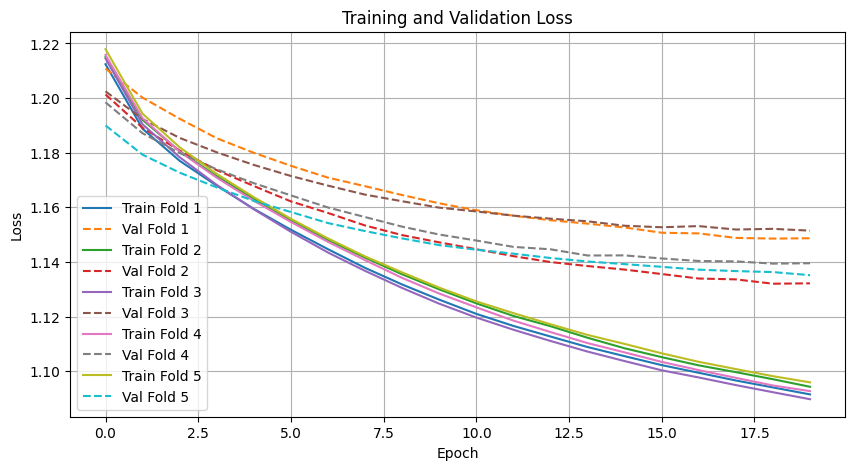

In [9]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for fold in range(len(eval_stats['loss']['train'])):
    plt.plot(range(epochs), eval_stats['loss']['train'][fold], label=f'Train Fold {fold + 1}')
    plt.plot(range(epochs), eval_stats['loss']['val'][fold], label=f'Val Fold {fold + 1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()

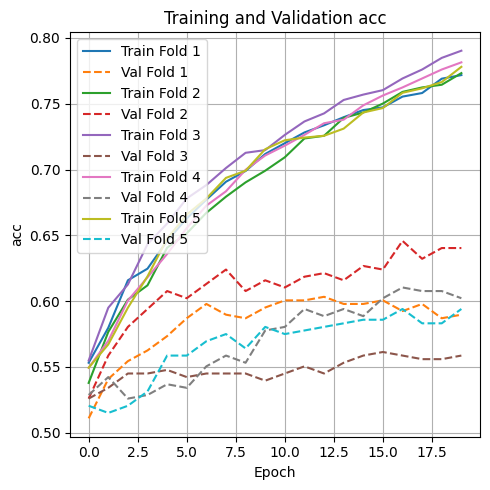

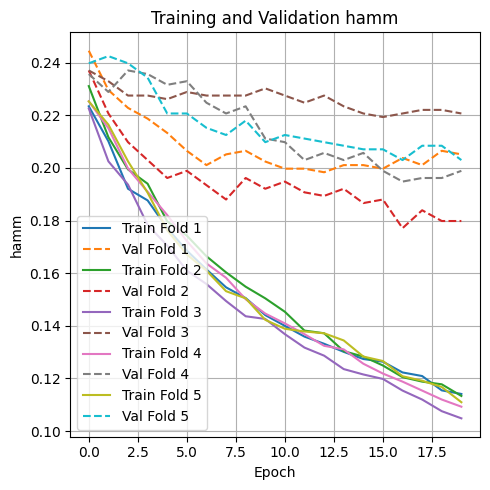

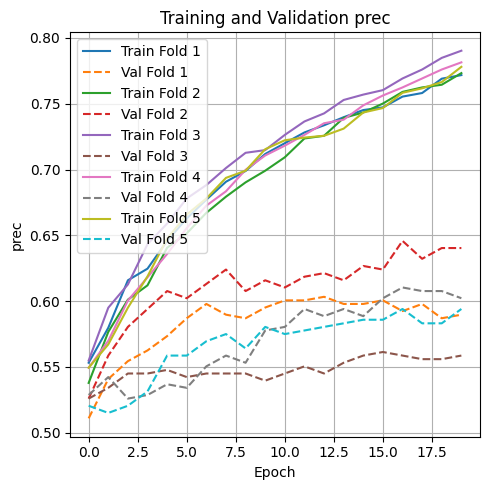

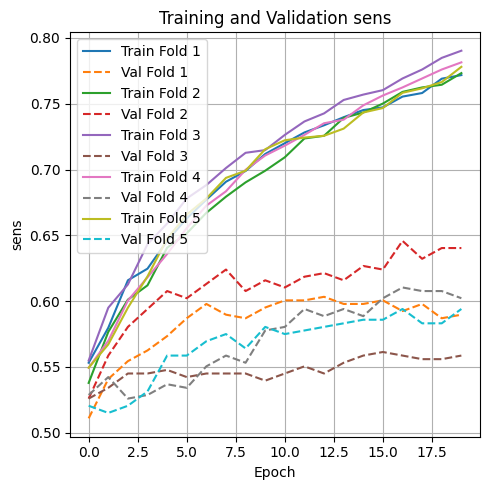

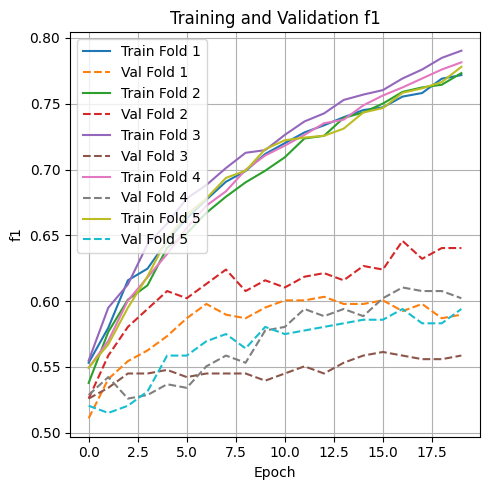

In [10]:
# Plotting
plot_metrics = METRICS.copy()
plot_metrics.remove('aps')
for metric in plot_metrics:
    fig, ax = plt.subplots(1, figsize=(5, 5))
    train_stats = eval_stats[metric]['train']
    val_stats = eval_stats[metric]['val']

    for fold in range(len(train_stats)):
        ax.plot(range(epochs), train_stats[fold], label=f'Train Fold {fold + 1}')
        ax.plot(range(epochs), val_stats[fold], label=f'Val Fold {fold + 1}', linestyle='--')
    ax.set_title(f'Training and Validation {metric}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{metric}')
    ax.grid(True)
    ax.legend()

    # axs[idx].legend(loc='upper left')

    plt.tight_layout()
    plt.show()


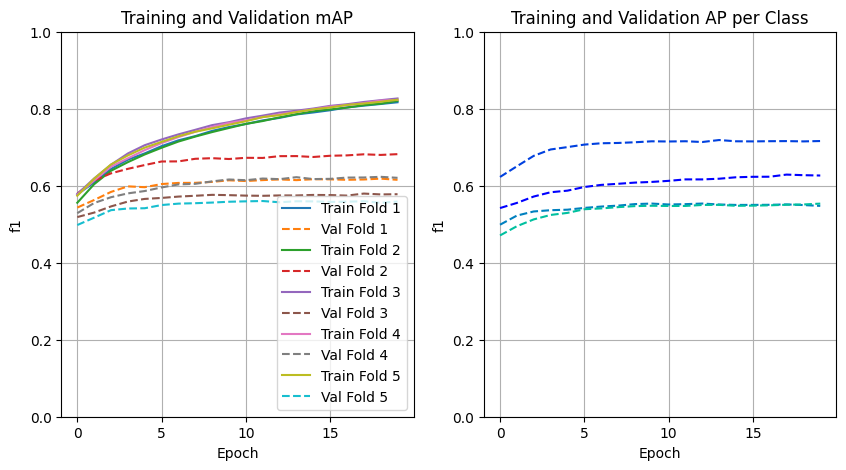

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


train_stats = np.array(eval_stats['aps']['train']).mean(axis=-1)
val_stats = np.array(eval_stats['aps']['val']).mean(axis=-1)

for fold in range(len(train_stats)):
    axs[0].plot(range(epochs), train_stats[fold], label=f'Train Fold {fold + 1}')
    axs[0].plot(range(epochs), val_stats[fold], label=f'Val Fold {fold + 1}', linestyle='--')

axs[0].set_ylim([0,1])
axs[0].set_title(f'Training and Validation mAP')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(f'{metric}')
axs[0].grid(True)
# axs[0].legend(loc='upper left')
axs[0].legend()





val_stats = np.array(eval_stats['aps']['val']).mean(axis=0).T
# Determine the number of smells
num_smells = len(val_stats)

# Create a colormap
cmap = plt.cm.winter

# Plot each line with a different color from the colormap
for smell in range(num_smells):
    color = cmap(float(smell) / num_smells)  # Generate a color from the colormap
    axs[1].plot(range(epochs), val_stats[smell], label=f'Val Class {smell + 1}', linestyle='--', color=color)

axs[1].set_ylim([0,1])
axs[1].set_title(f'Training and Validation AP per Class')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel(f'{metric}')
axs[1].grid(True)
# ax.legend(loc='lower left')

# Show or save the plot
plt.show()  # Or plt.savefig('your_plot.png')

In [12]:
for metric in METRICS:
    val_stats_t = np.array(eval_stats[metric]['val']).mean(axis=0)
    if metric == 'aps':
        metric = 'mAP'
        val_stats_t = val_stats_t.mean(axis=-1)

    print(f'{metric}:\t', val_stats_t[-1])


aps = np.array(eval_stats['aps']['val']).mean(axis=0)[-1]
print(f'aps:\t', aps)

acc:	 0.596953856178178
hamm:	 0.20152307191091104
prec:	 0.596953856178178
sens:	 0.596953856178178
f1:	 0.596953856178178
mAP:	 0.6109228077296389
aps:	 [0.62649506 0.71606876 0.54760644 0.55352097]


In [13]:
acc:	 0.5925941831536548
hamm:	 0.2037029084231726
prec:	 0.5925941831536548
sens:	 0.5925941831536548
f1:	     0.5925941831536548
mAP:	 0.6170596010176623
aps:	 [0.63895166 0.72781378 0.54870765 0.55276532]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3722483669.py, line 7)